In [6]:
import pandas as pd
import numpy as np
import pickle

In [2]:
with open(r'2016_filtered_review.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t\t') for doc in f]
    docs = [(doc[1], int(doc[2])) for doc in docs if len(doc) == 3]
    # To read the second and third column info from each row
    texts, scores = zip(*docs)
    # 둘을 분리해서 별도의 list 변수로 저장

In [3]:
filtered_texts = []
filtered_labels = []

for text, score in zip(texts, scores):
    if 3 <= score <= 9:
        continue
        
    # 평점 기준으로 문서에 label을 부여
    # 1 ~ 3 -> 부정, 0
    # 9 ~ 10 -> 긍정, 1
    filtered_texts.append(text)
    filtered_labels.append(1 if score > 9 else 0)

In [4]:
filtered_words = [doc.strip().split() for doc in filtered_texts]

In [5]:
print(filtered_words[:2])

[['진심', '쓰레기', '영화', '만들', '무서', '알', '쫄아', '틀었', '이건', '뭐', '웃', '거리', '없는', '쓰레기', '영화', '임'], ['역대', '좀비', '영화', '가장', '최고다', '원작', '만화', '읽어', '보려', '영화', '보고', '결정', '하려', '감독', '간츠', '실사', '했', '사람', '거르려', '그냥', '봤', '정말', '흠잡', '없는', '최고', '좀비', '영화', '잔인', '거', '싫어하지', '참고', '볼', '만하', '로미', '인물', '왜', '그런', '모르']]


In [7]:
total_words = []
for words in filtered_words:
    total_words.extend(words)

In [8]:
from collections import Counter
c = Counter(total_words)

In [9]:
max_features = 10000
common_words = [ word for word, count in c.most_common(max_features)]

In [10]:
words_dic ={}
# 각 단어에 대해서 index 생성하기
for index, word in enumerate(common_words):
    words_dic[word]=index+1

In [13]:
print(common_words[:100])

['영화', '너무', '봤', '좋', '진짜', '정말', '보고', '연기', '감동', '최고', '배우', '입니', '였', '보는', '더', '했', '본', '스토리', '사람', '봐', '이', '것', '시간', '잘', '평점', '재밌게', '볼', '꼭', '재미', '점', '생각', '역시', '하는', '이런', '재밌었', '잼', '수', '기대', '있는', '그냥', '아이', '알', '말', '아니', '재밌어', '완전', '그', '할', '내용', '마지막', '넘', '왜', '돈', '나', '처음', '내', '또', '때', '보세', '좀비', '없는', '다시', '모르', '보면', '감독', '눈물', '한번', '같은', '정도', '짱', '재미있게', '하나', '같아', '들', '좀', '왔', '한', '장면', '와', '거', '분', '재밌', '있었', '재미있었', '액션', '재미없', '마음', '인생', '우리', '대박', '느낌', '안', '이었', '마블', '보기', '임', '저', '듯', '합', '가슴']


In [14]:
# 각 문서를 상위 10000개 단어들에 대해서 index 번호로 표현하기
filtered_indexed_words = []
for review in filtered_words:
    indexed_words=[]
    for word in review:
        try:
            indexed_words.append(words_dic[word])
        except:
            pass
    filtered_indexed_words.append(indexed_words)

In [15]:
max_len = 100

In [16]:
from tensorflow.keras.preprocessing import sequence
X = sequence.pad_sequences(filtered_indexed_words, maxlen=max_len)

In [17]:
filtered_indexed_words[0]

[173, 245, 1, 315, 1970, 42, 148, 120, 1240, 686, 61, 245, 1, 96]

In [18]:
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  173,  245,
          1,  315, 1970,   42,  148,  120, 1240,  686,   61,  245,    1,
         96])

In [19]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, filtered_labels, test_size=0.1)

In [21]:
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [22]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [23]:
model = models.Sequential()
model.add(layers.Embedding(max_features+1, 32)) # +1 을 하는 이유, index 번호 0이 포함되었기 때문
model.add(layers.SimpleRNN(32))
model.add(layers.Dense(2, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320032    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 322,178
Trainable params: 322,178
Non-trainable params: 0
_________________________________________________________________


In [24]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

In [26]:
history = model.fit(X_train, y_train_one_hot, epochs=10, batch_size=256, validation_split=0.2)

Epoch 1/10
1181/1181 [==============================] - 74s 63ms/step - loss: 0.1963 - acc: 0.9225 - val_loss: 0.1775 - val_acc: 0.9311
Epoch 2/10
1181/1181 [==============================] - 74s 63ms/step - loss: 0.1660 - acc: 0.9363 - val_loss: 0.8875 - val_acc: 0.6172
Epoch 3/10
1181/1181 [==============================] - 80s 68ms/step - loss: 0.1531 - acc: 0.9418 - val_loss: 0.1746 - val_acc: 0.9332
Epoch 4/10
1181/1181 [==============================] - 78s 66ms/step - loss: 0.1433 - acc: 0.9462 - val_loss: 0.1839 - val_acc: 0.9315
Epoch 5/10
1181/1181 [==============================] - 75s 63ms/step - loss: 0.1328 - acc: 0.9508 - val_loss: 0.1892 - val_acc: 0.9303: 0.9 - ETA: 1s - loss: 0.132 - ETA: 0s - loss: 0.1328 - acc:
Epoch 6/10
1181/1181 [==============================] - 73s 61ms/step - loss: 0.1238 - acc: 0.9542 - val_loss: 0.1955 - val_acc: 0.9283
Epoch 7/10
1181/1181 [==============================] - 73s 62ms/step - loss: 0.1189 - acc: 0.9565 - val_loss: 0.1987 - val

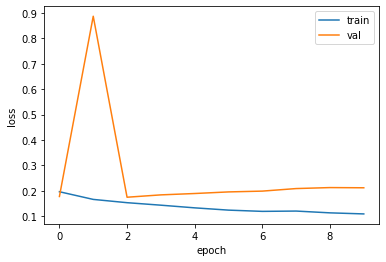

In [27]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [28]:
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
print('test_acc:', test_acc)

1312/1312 [==============================] - 10s 8ms/step - loss: 0.2102 - acc: 0.9231: 1s - loss
test_acc: 0.9231300354003906
